In [ ]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


%matplotlib inline
# load hourly data
hourly_data = pd.read_csv('https://raw.githubusercontent.com/'\
                          'PacktWorkshops/'\
                          'The-Data-Analysis-Workshop/'\
                          'master/Chapter01/data/hour.csv')

In [ ]:
# print some generic statistics about the data
print(f"Shape of data: {hourly_data.shape}")
print(f"Number of missing values in the data:\
{hourly_data.isnull().sum().sum()}")

Shape of data: (17379, 17)
Number of missing values in the data:0


In [ ]:
# get statistics on the numerical columns
hourly_data.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


In [ ]:
# create a copy of the original data
preprocessed_data = hourly_data.copy()

In [ ]:
# transform seasons
seasons_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
preprocessed_data['season'] = preprocessed_data['season'].apply(lambda x: seasons_mapping[x])

In [ ]:
# transform yr
yr_mapping = {0: 2011, 1: 2012}
preprocessed_data['yr'] = preprocessed_data['yr'].apply(lambda x: yr_mapping[x])

In [ ]:
# transform weekday
weekday_mapping = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
preprocessed_data['weekday'] = preprocessed_data['weekday'].apply(lambda x: weekday_mapping[x])

In [ ]:
# transform weathersit
weather_mapping = {1: 'clear', 2: 'cloudy', 3: 'light_rain_snow', 4: 'heavy_rain_snow'}
preprocessed_data['weathersit'] = preprocessed_data['weathersit'].apply(lambda x: weather_mapping[x])

In [ ]:
# transform hum and windspeed
preprocessed_data['hum'] = preprocessed_data['hum']*100
preprocessed_data['windspeed'] = preprocessed_data['windspeed']*67

In [ ]:
# visualize preprocessed columns
cols = ['season', 'yr', 'weekday','weathersit', 'hum', 'windspeed']
preprocessed_data[cols].sample(10, random_state=123)

,season,yr,weekday,weathersit,hum,windspeed
5792,summer,2011,Saturday,clear,74.0,8.9981
7823,fall,2011,Sunday,clear,43.0,31.0009
15426,fall,2012,Tuesday,cloudy,77.0,6.0032
15028,fall,2012,Sunday,clear,51.0,22.0028
12290,spring,2012,Friday,cloudy,89.0,12.9980
3262,spring,2011,Friday,clear,64.0,7.0015
10763,spring,2012,Thursday,clear,42.0,23.9994
12384,spring,2012,Tuesday,light_rain_snow,82.0,11.0014
6051,summer,2011,Wednesday,clear,52.0,19.0012
948,winter,2011,Saturday,clear,80.0,0.0000


In [ ]:
"""
assert that total number of rides is equal to the sum of registered and
casual ones
"""
assert (preprocessed_data.casual \
        + preprocessed_data.registered \
        == preprocessed_data.cnt).all(), \
        'Sum of casual and registered rides not equal '\
        'to total number of rides'

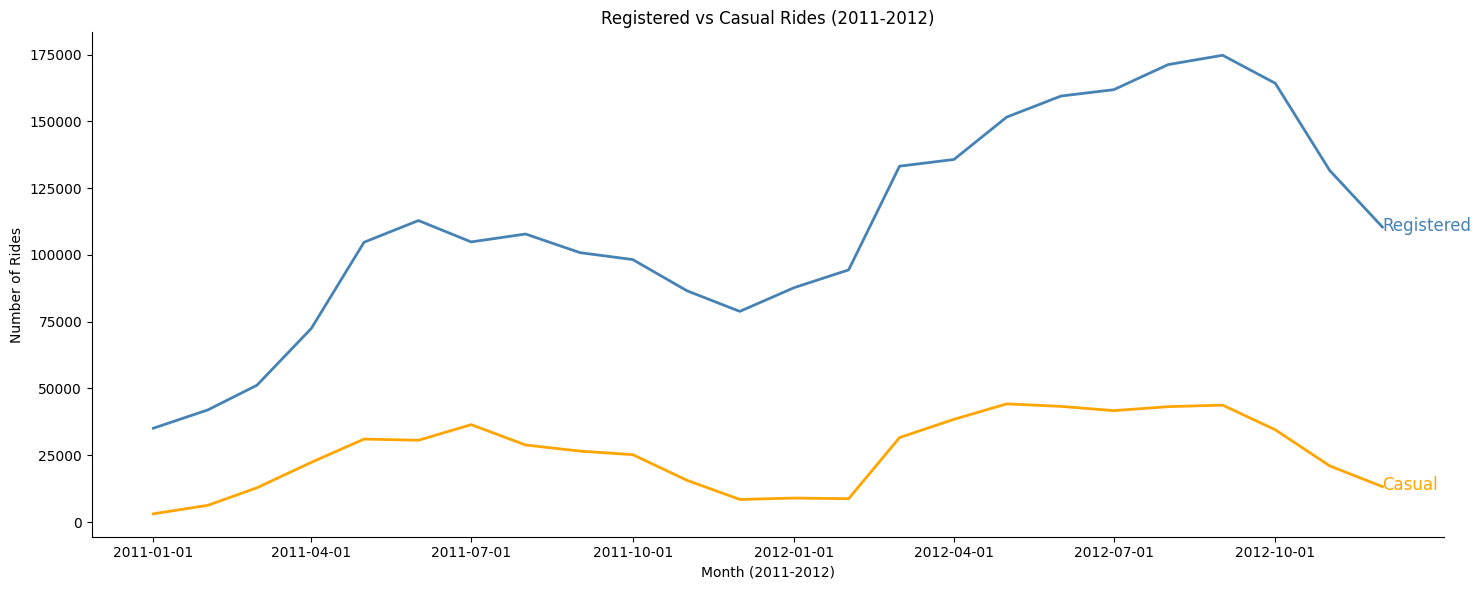

In [ ]:
# Plot the line graph
plt.figure(figsize=(15, 6))

# Recreate the datetime column from the actual year and month
preprocessed_data['datetime'] = pd.to_datetime(dict(
    year=preprocessed_data['yr'],
    month=preprocessed_data['mnth'],
    day=1
))

# Group by month and calculate total registered and casual rides
monthly_rides_combined = preprocessed_data.groupby(preprocessed_data['datetime'].dt.to_period('M'))[['registered', 'casual']].sum()

# Convert PeriodIndex to Timestamp for plotting
monthly_rides_combined.index = monthly_rides_combined.index.to_timestamp()

# Plot registered rides
plt.plot(monthly_rides_combined.index, monthly_rides_combined['registered'], label='Registered Rides',
         color="#4682B4", linewidth=2)

# Plot casual rides
plt.plot(monthly_rides_combined.index, monthly_rides_combined['casual'], label='Casual Rides',
         color="orange", linewidth=2)

# Adding title and labels
plt.title('Registered vs Casual Rides (2011-2012)')
plt.xlabel('Month (2011-2012)')
plt.ylabel('Number of Rides')

ticks = monthly_rides_combined.index[::3]
plt.xticks(ticks, rotation=0, ha='center')

# Remove the grid, and upper and right borders
plt.grid(False)
sns.despine()

# Add line labels at the end of the lines with vertical offset
plt.text(monthly_rides_combined.index[-1], monthly_rides_combined['registered'].iloc[-1] + 550,
         'Registered', color="#4682B4", verticalalignment='center', horizontalalignment='left', fontsize=12)

plt.text(monthly_rides_combined.index[-1], monthly_rides_combined['casual'].iloc[-1] + 550,
         'Casual', color="orange", verticalalignment='center', horizontalalignment='left', fontsize=12)

# Remove legend box
plt.legend(frameon=False)
plt.legend().set_visible(False)
# Ensure the layout fits well
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-13-ca208c845cea>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data[agg_data['type'] == 'registered'], x='hr', y='count', palette='Blues')


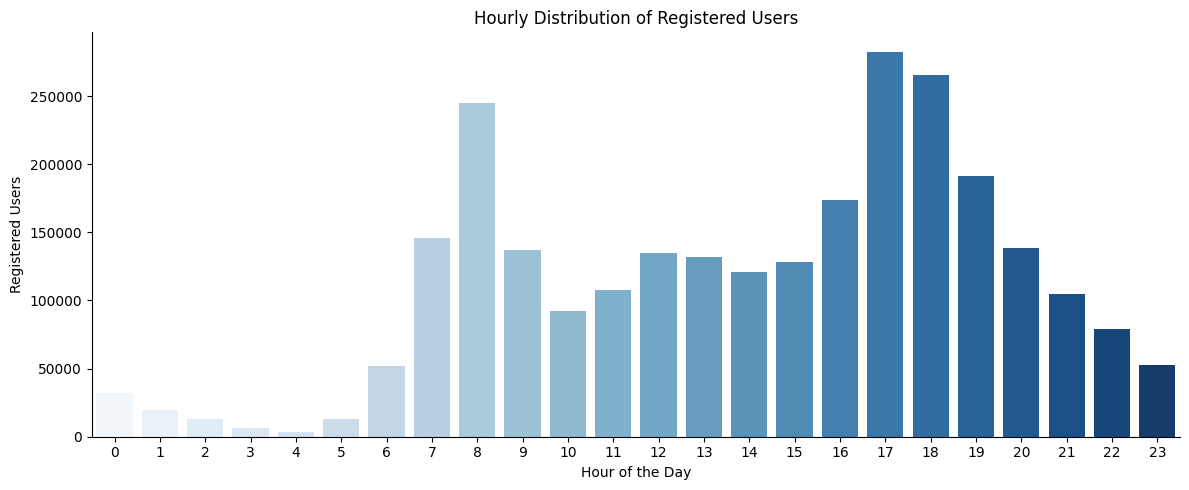

<ipython-input-13-ca208c845cea>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data[agg_data['type'] == 'casual'], x='hr', y='count', palette='Oranges')


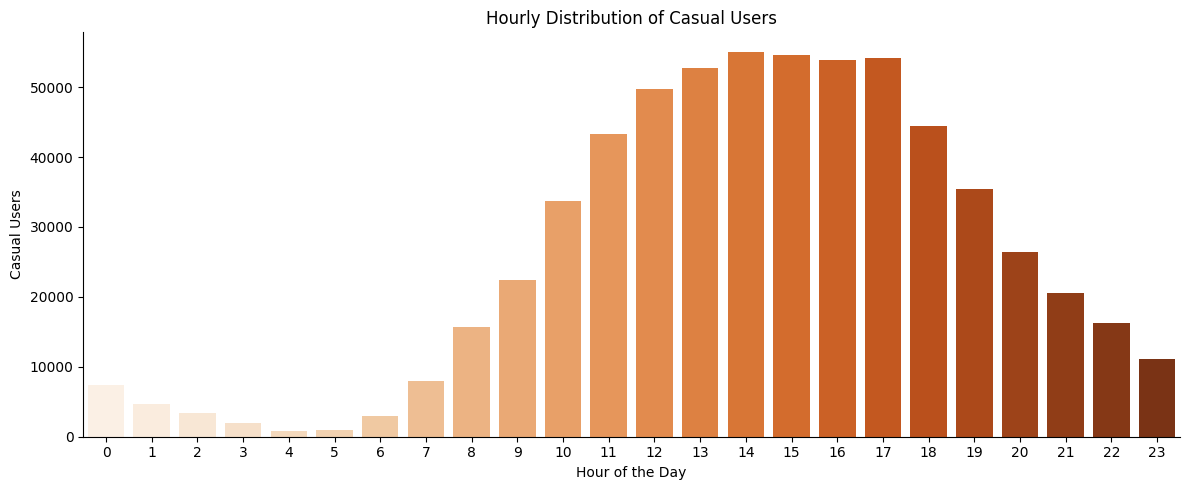

In [ ]:
plot_data = preprocessed_data[['hr', 'weekday', 'registered', 'casual']]

# Melt data into long format
plot_data = plot_data.melt(id_vars=['hr', 'weekday'],
                           value_vars=['registered', 'casual'],
                           var_name='type', value_name='count')

# Step 2: Aggregate by hour and type (sum over all weekdays)
agg_data = plot_data.groupby(['hr', 'type'])['count'].sum().reset_index()

# Step 3: Plot - Registered
plt.figure(figsize=(12, 5))
sns.barplot(data=agg_data[agg_data['type'] == 'registered'], x='hr', y='count', palette='Blues')
plt.title("Hourly Distribution of Registered Users")
plt.xlabel("Hour of the Day")
plt.ylabel("Registered Users")
plt.xticks(rotation=0)
sns.despine(top=True, left=False)
plt.tight_layout()
plt.show()

# Step 4: Plot - Casual
plt.figure(figsize=(12, 5))
sns.barplot(data=agg_data[agg_data['type'] == 'casual'], x='hr', y='count', palette='Oranges')
plt.title("Hourly Distribution of Casual Users")
plt.xlabel("Hour of the Day")
plt.ylabel("Casual Users")
plt.xticks(rotation=0)
sns.despine(top=True, left=False)
plt.tight_layout()
plt.show()


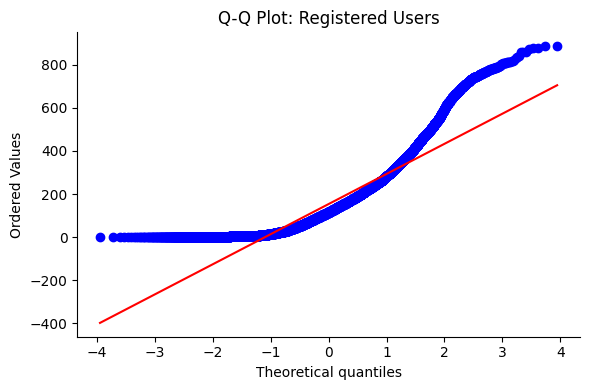

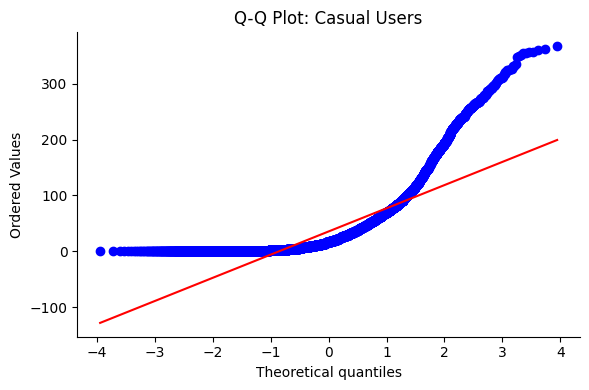

In [ ]:
hourly_registered = preprocessed_data['registered']
hourly_casual = preprocessed_data['casual']

shapiro_stat, shapiro_p = stats.shapiro(hourly_registered.sample(5000, random_state=1)) # sample to avoid size limits

dagostino_stat, dagostino_p = stats.normaltest(hourly_registered)

plt.figure(figsize=(6, 4))
stats.probplot(hourly_registered, dist="norm", plot=plt)
plt.title("Q-Q Plot: Registered Users")
plt.tight_layout()
sns.despine(top=True, left=False)
plt.show()


shapiro_stat, shapiro_p = stats.shapiro(hourly_casual.sample(5000, random_state=1))

dagostino_stat, dagostino_p = stats.normaltest(hourly_casual)
plt.figure(figsize=(6, 4))
stats.probplot(hourly_casual, dist="norm", plot=plt)
plt.title("Q-Q Plot: Casual Users")
plt.tight_layout()
sns.despine(top=True, left=False)
plt.show()

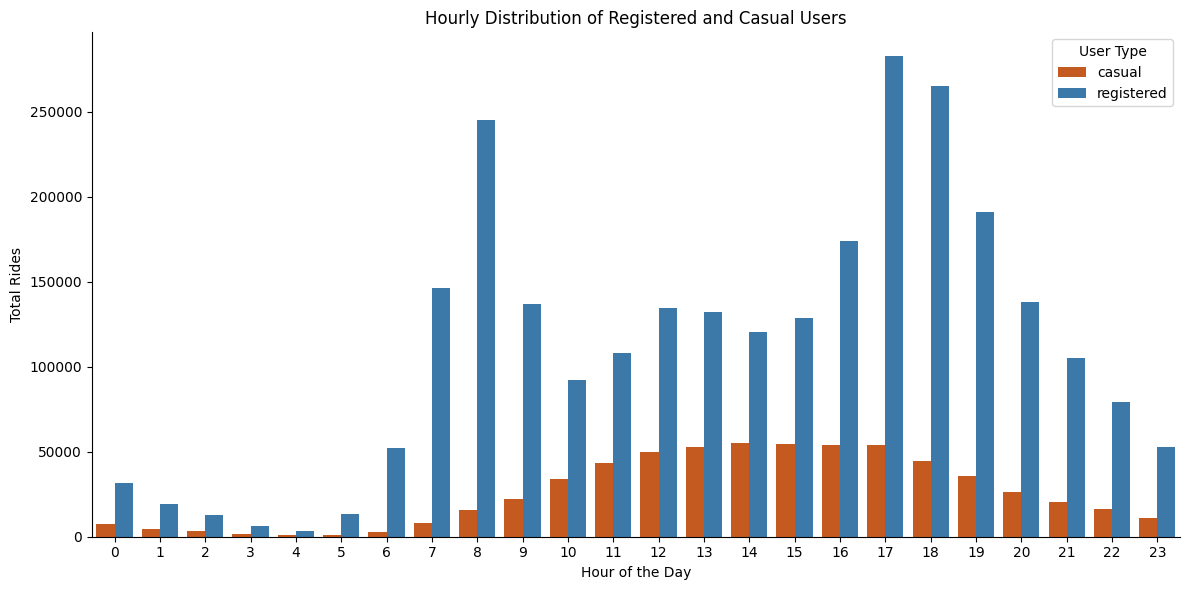

In [ ]:

# Step 1: Prepare the data
plot_data = preprocessed_data[['hr', 'weekday', 'registered', 'casual']]

# Melt data into long format
plot_data = plot_data.melt(id_vars=['hr', 'weekday'],
                           value_vars=['registered', 'casual'],
                           var_name='type', value_name='count')

# Step 2: Aggregate by hour and type (sum over all weekdays)
agg_data = plot_data.groupby(['hr', 'type'])['count'].sum().reset_index()

# Step 3: Combined Plot with original-style colors
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_data, x='hr', y='count', hue='type',
            palette={'registered': sns.color_palette("Blues")[4],
                     'casual': sns.color_palette("Oranges")[4]})

plt.title("Hourly Distribution of Registered and Casual Users")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Rides")
plt.xticks(rotation=0)  # keep x-axis labels horizontal
plt.legend(title="User Type")
plt.tight_layout()
sns.despine(top=True, left=False)
plt.show()

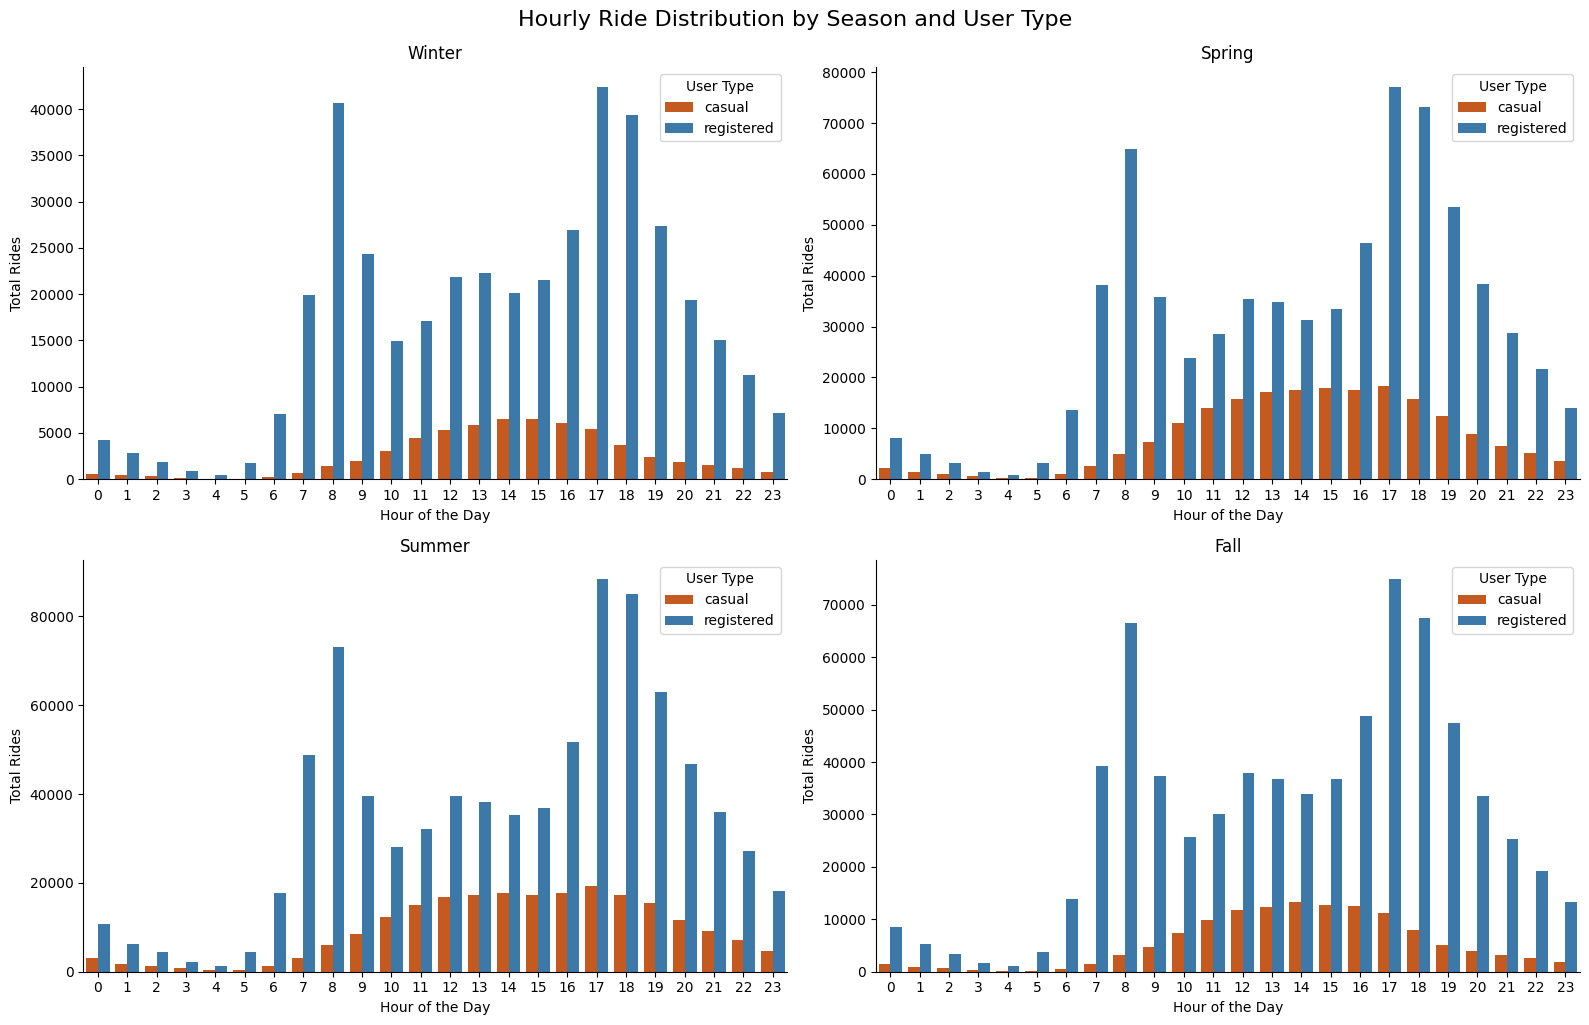

In [ ]:
# Step 1: Prepare the data
plot_data = preprocessed_data[['hr', 'season', 'registered', 'casual']]

# Melt into long format
plot_data = plot_data.melt(id_vars=['hr', 'season'],
                           value_vars=['registered', 'casual'],
                           var_name='type', value_name='count')

# Step 2: Aggregate by hour, season, and type
agg_data = plot_data.groupby(['hr', 'season', 'type'])['count'].sum().reset_index()

# Step 3: Define consistent colors
palette = {'registered': sns.color_palette("Blues")[4],
           'casual': sns.color_palette("Oranges")[4]}

# Step 4: Plot all four seasons in a 2x2 grid
seasons = ['winter', 'spring', 'summer', 'fall']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, season in enumerate(seasons):
    season_data = agg_data[agg_data['season'] == season]
    sns.barplot(data=season_data, x='hr', y='count', hue='type',
                palette=palette, ax=axes[i])

    axes[i].set_title(f"{season.capitalize()}")
    axes[i].set_xlabel("Hour of the Day")
    axes[i].set_ylabel("Total Rides")
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].legend(title="User Type")

plt.tight_layout()
sns.despine(top=True, left=False)
plt.suptitle("Hourly Ride Distribution by Season and User Type", fontsize=16, y=1.02)
plt.show()


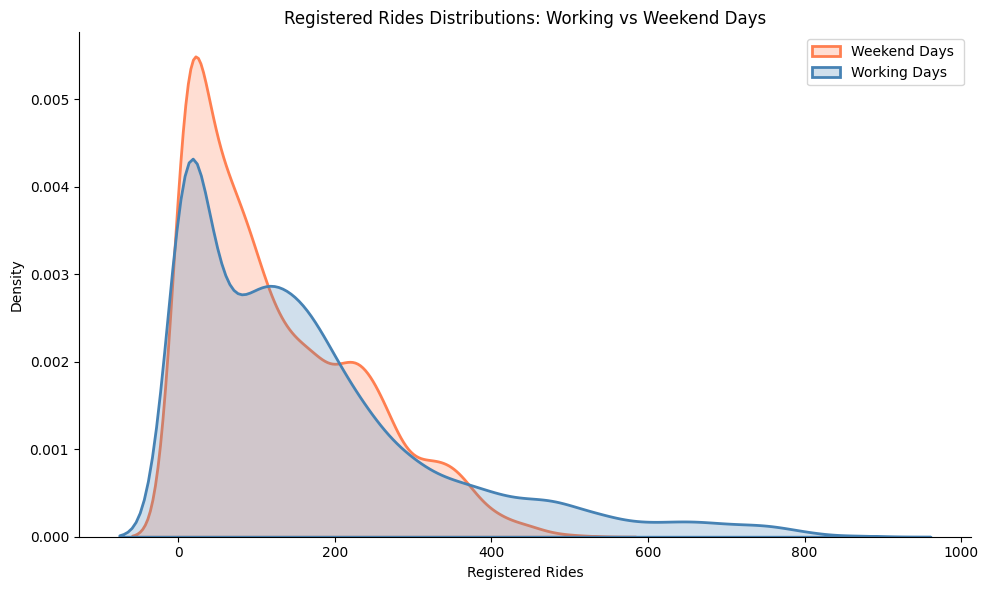

In [ ]:
#H_0 : average registered rides over weekdays-average registered rides over weekend=0
#and
#H_a : average registered rides over weekdays-average registered rides over weekend≠0
# define mask, indicating if the day is weekend or work day
weekend_days = ['Saturday', 'Sunday']
weekend_mask = preprocessed_data.weekday.isin(weekend_days)
workingdays_mask = ~preprocessed_data.weekday.isin(weekend_days)
# select registered rides for the weekend and working days
weekend_data = preprocessed_data.registered[weekend_mask]
workingdays_data = preprocessed_data.registered[workingdays_mask]
# Perform two-sided t-test (if required)
t_stat, p_value = stats.ttest_ind(weekend_data, workingdays_data, equal_var=False)

# Plot distributions of registered rides for working vs weekend days
plt.figure(figsize=(10, 6))
sns.kdeplot(weekend_data, label='Weekend Days ', color='coral', fill=True, linewidth=2)
sns.kdeplot(workingdays_data, label=f'Working Days', color='steelblue', fill=True, linewidth=2)

plt.title("Registered Rides Distributions: Working vs Weekend Days")
plt.xlabel('Registered Rides')
plt.ylabel('Density')

# Adding legend
plt.legend()

# Finalize plot
sns.despine(top=True, left=False)
plt.tight_layout()
plt.show()

In [ ]:
# perform ttest
test_res = ttest_ind(weekend_data, workingdays_data)
#print(f"p-value: {test_res[1]:.03f}")

mean_weekend = np.mean(weekend_data)
mean_workingdays = np.mean(workingdays_data)

# Calculate the standard error for both groups
std_error_weekend = stats.sem(weekend_data)
std_error_workingdays = stats.sem(workingdays_data)


confidence_level = 0.95

# Calculate the confidence intervals for both groups
ci_weekend = stats.t.interval(confidence_level, len(weekend_data)-1, loc=mean_weekend, scale=std_error_weekend)
ci_workingdays = stats.t.interval(confidence_level, len(workingdays_data)-1, loc=mean_workingdays, scale=std_error_workingdays)

# Perform two-sample t-test (assuming unequal variances)
t_stat, p_value = stats.ttest_ind(weekend_data, workingdays_data, equal_var=False)

# Print the results

print(f"Weekend Days Mean: {mean_weekend:.2f} ,Weekend Days 95% CI: ({ci_weekend[0]:.2f}, {ci_weekend[1]:.2f})")

print(f"Working Days Mean: {mean_workingdays:.2f} ,Working Days 95% CI: ({ci_workingdays[0]:.2f}, {ci_workingdays[1]:.2f})")



Weekend Days Mean: 125.14 ,Weekend Days 95% CI: (122.17, 128.11)
Working Days Mean: 165.40 ,Working Days 95% CI: (162.50, 168.30)


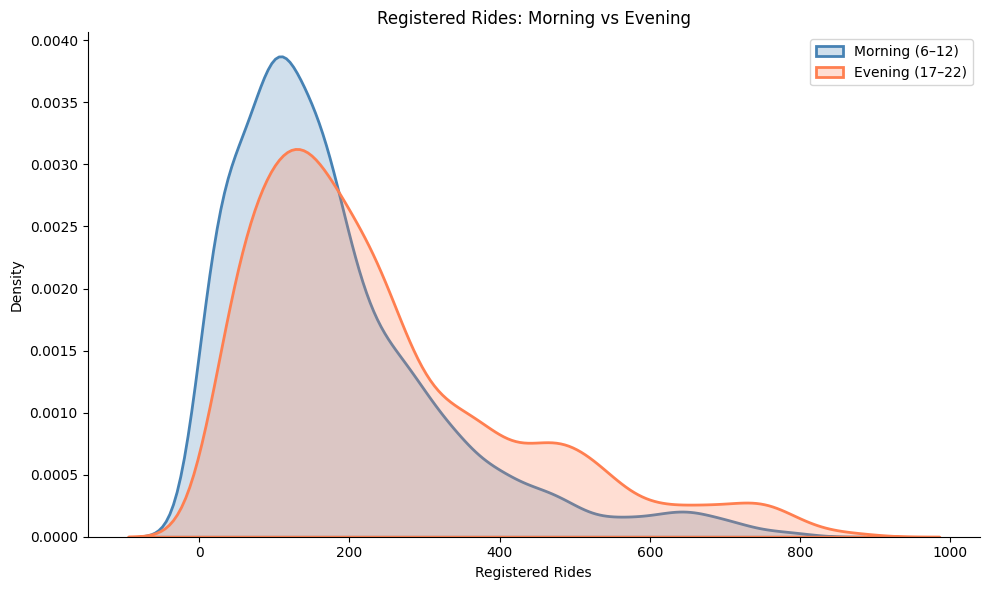

In [ ]:
#H₀: Mean registered rides in the morning = evening

#H₁: Mean registered rides in the morning ≠ evening

# Define morning and evening hour ranges
morning_hours = list(range(6, 13))   # 6 AM to 12 PM
evening_hours = list(range(17, 23))  # 5 PM to 10 PM

# Filter the data
morning_data = preprocessed_data[preprocessed_data['hr'].isin(morning_hours)]['registered']
evening_data = preprocessed_data[preprocessed_data['hr'].isin(evening_hours)]['registered']

# Perform two-sided t-test
t_stat, p_value = stats.ttest_ind(evening_data, morning_data, equal_var=False)

# Plot KDEs with p-value in legend
plt.figure(figsize=(10, 6))
sns.kdeplot(morning_data, label='Morning (6–12)', color='steelblue', fill=True, linewidth=2)
sns.kdeplot(evening_data, label=f'Evening (17–22)', color='coral', fill=True, linewidth=2)

plt.title('Registered Rides: Morning vs Evening')
plt.xlabel('Registered Rides')
plt.ylabel('Density')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
#H₀: Mean registered rides in the morning = evening

#H₁: Mean registered rides in the morning ≠ evening

# Define morning and evening hour ranges
morning_hours = list(range(6, 13))   # 6 AM to 12 PM
evening_hours = list(range(17, 23))  # 5 PM to 10 PM

# Filter the data
morning_data = preprocessed_data[preprocessed_data['hr'].isin(morning_hours)]['registered']
evening_data = preprocessed_data[preprocessed_data['hr'].isin(evening_hours)]['registered']

# Perform two-sided t-test
_, p_value = stats.ttest_ind(evening_data, morning_data, equal_var=False)

morning_data = preprocessed_data[(preprocessed_data['hr'] >= 6) & (preprocessed_data['hr'] < 12)]['registered']
evening_data = preprocessed_data[(preprocessed_data['hr'] >= 18) & (preprocessed_data['hr'] < 24)]['registered']

# Calculate the mean and standard error for Morning rides
mean_morning = np.mean(morning_data)
std_error_morning = stats.sem(morning_data)

# Calculate the mean and standard error for Evening rides
mean_evening = np.mean(evening_data)
std_error_evening = stats.sem(evening_data)

# Set confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the confidence intervals for both Morning and Evening rides
ci_morning = stats.t.interval(confidence_level, len(morning_data)-1, loc=mean_morning, scale=std_error_morning)
ci_evening = stats.t.interval(confidence_level, len(evening_data)-1, loc=mean_evening, scale=std_error_evening)

# Print the results
print(f"Morning Rides Mean: {mean_morning:.2f} | Morning Rides 95% CI: ({ci_morning[0]:.2f}, {ci_morning[1]:.2f})")

print(f"Evening Rides Mean: {mean_evening:.2f} | Evening Rides 95% CI: ({ci_evening[0]:.2f}, {ci_evening[1]:.2f})")

# Print p-value
#print(f"P-value: {p_value:.4f}")

Morning Rides Mean: 179.12 | Morning Rides 95% CI: (174.61, 183.64)
Evening Rides Mean: 190.45 | Evening Rides 95% CI: (185.94, 194.96)


ANOVA Test - F-statistic: 298.9684, p-value: 0.0000


<ipython-input-21-3ab193fdc3bb>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=preprocessed_data, x='season', y='registered', palette='Blues')


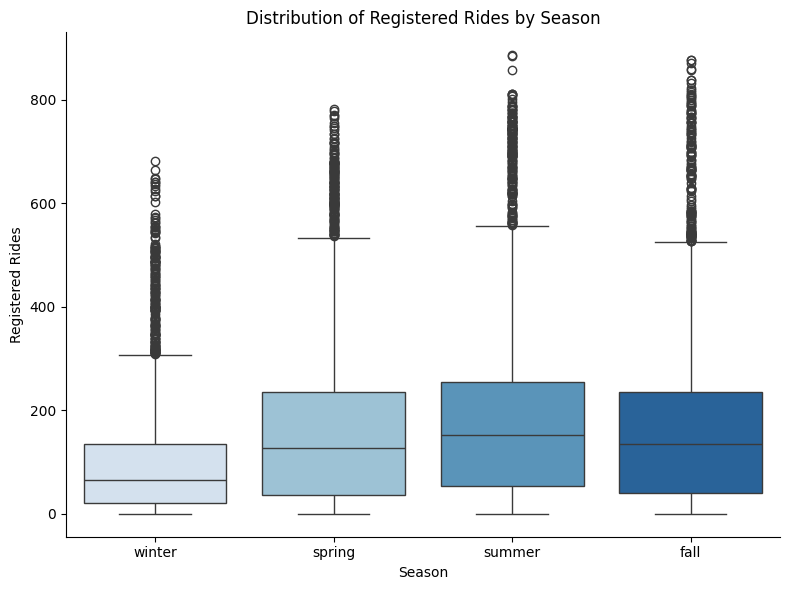

In [ ]:
#H₀ (null hypothesis): All seasons have the same mean number of registered rides.

#H₁ (alternative hypothesis):no season has the same mean.

# Group the data by season
season_groups = preprocessed_data.groupby('season')['registered'].apply(list)

# Perform one-way ANOVA test
f_stat, p_value = stats.f_oneway(*season_groups)

# Print results
print(f"ANOVA Test - F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

# Create box plot to visualize registered rides across seasons
plt.figure(figsize=(8, 6))
sns.boxplot(data=preprocessed_data, x='season', y='registered', palette='Blues')
plt.title('Distribution of Registered Rides by Season')
plt.xlabel('Season')
plt.ylabel('Registered Rides')
sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
target = 'registered'
features = ['temp', 'hum', 'windspeed', 'hr', 'season', 'weathersit', 'workingday']

In [ ]:
df_encoded = pd.get_dummies(preprocessed_data[features + [target]], drop_first=True)

In [ ]:

X = df_encoded.drop(columns=target)
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:


y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

coefficients = pd.Series(model.coef_, index=X.columns)
print(coefficients.sort_values(ascending=False))

Mean Squared Error: 15605.75
R² Score: 0.2930
temp                          241.533221
workingday                     39.753953
weathersit_heavy_rain_snow     20.583783
weathersit_cloudy               8.436399
hr                              6.125380
windspeed                       0.241096
hum                            -1.443304
weathersit_light_rain_snow    -26.083107
season_spring                 -45.322192
season_winter                 -57.388818
season_summer                 -58.511838
dtype: float64


In [ ]:
X_test

,temp,hum,windspeed,hr,workingday,season_spring,season_summer,season_winter,weathersit_cloudy,weathersit_heavy_rain_snow,weathersit_light_rain_snow
12830,0.80,27.0,12.9980,19,0,False,True,False,False,False,False
8688,0.24,41.0,15.0013,20,0,False,False,True,False,False,False
7091,0.32,66.0,19.0012,2,1,False,False,False,False,False,False
12230,0.78,52.0,23.9994,19,1,True,False,False,False,False,False
431,0.26,56.0,26.0027,0,1,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
6759,0.56,94.0,11.0014,5,1,False,False,False,True,False,False
13989,0.64,78.0,12.9980,2,0,False,True,False,False,False,True
173,0.20,59.0,23.9994,12,0,False,False,True,True,False,False
16192,0.48,77.0,11.0014,10,0,False,False,False,False,False,False


Mean Squared Error: 19485.41
R² Score: 0.1173
Coefficient (Slope): 6.5658
Intercept: 23.9423


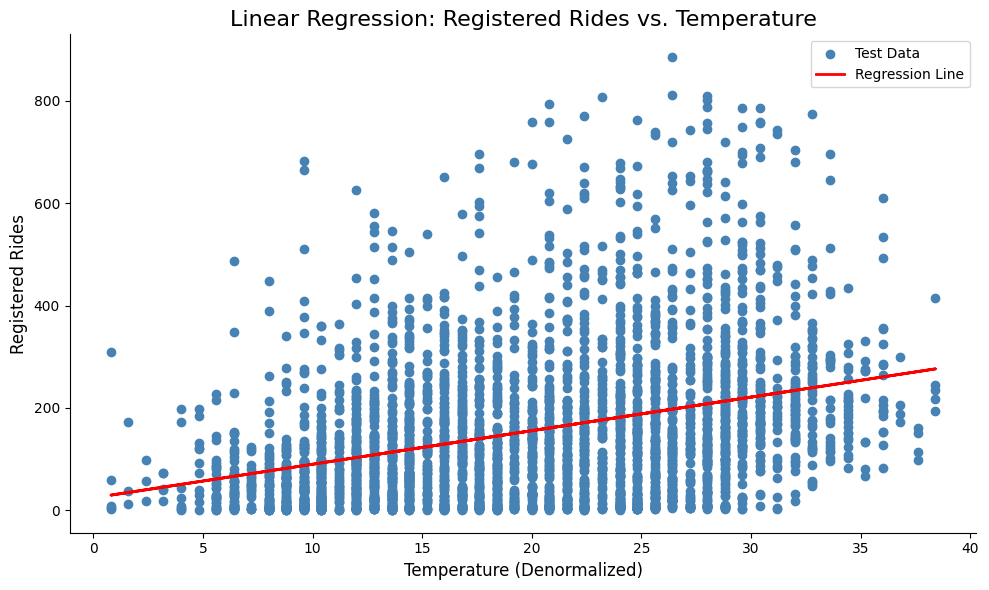

In [ ]:
preprocessed_data['denormalized_temp'] = preprocessed_data['temp'] * 40

# Extract the target ('registered') and the denormalized feature ('denormalized_temp')
X = preprocessed_data[['denormalized_temp']]  # Feature (independent variable)
y = preprocessed_data['registered']  # Target (dependent variable)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model14
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

# Print the coefficient (slope) and intercept
print(f"Coefficient (Slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

# Plotting the regression line with denormalized 'temp'
plt.figure(figsize=(10, 6))

# Scatter plot of the data with denormalized temp
plt.scatter(X_test, y_test, color='#4682B4', label='Test Data')

# Regression line: predicted values vs. denormalized temp values
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')

# Titles and labels
plt.title('Linear Regression: Registered Rides vs. Temperature', fontsize=16)
plt.xlabel('Temperature (Denormalized)', fontsize=12)
plt.ylabel('Registered Rides', fontsize=12)

# Display the legend
plt.legend()

# Show the plot
sns.despine(top=True, left=False)
plt.tight_layout()
plt.show()

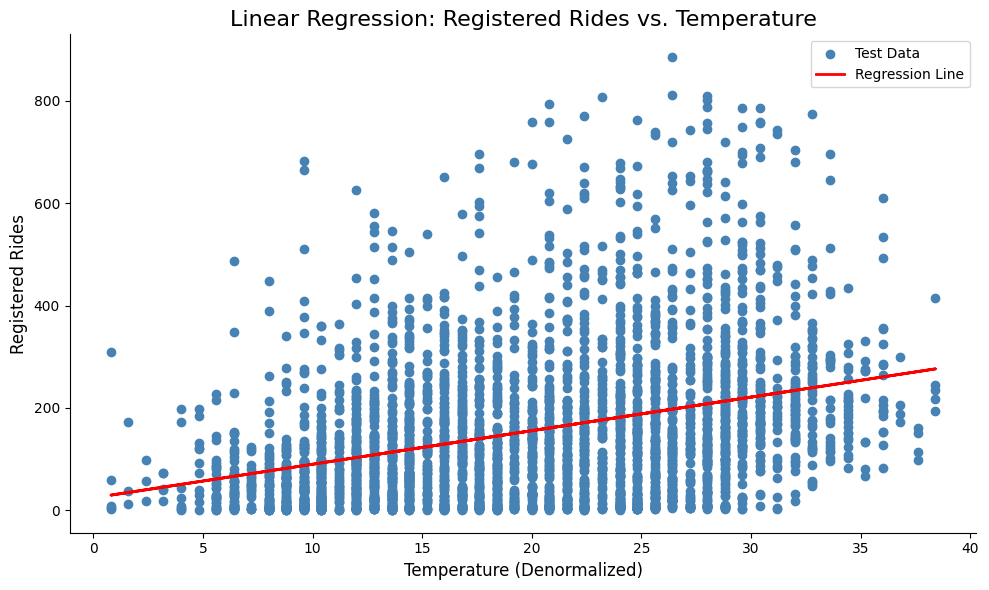

In [ ]:
# If X_test is a DataFrame with one feature (e.g., 'temp'), extract it as a 1D array
if isinstance(X_test, pd.DataFrame):
    x_vals = X_test.iloc[:, 0]
else:
    x_vals = X_test  # Assume already 1D

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_test, color='#4682B4', label='Test Data')

# Regression line
plt.plot(x_vals, y_pred, color='red', linewidth=2, label='Regression Line')

# Titles and labels
plt.title('Linear Regression: Registered Rides vs. Temperature', fontsize=16)
plt.xlabel('Temperature (Denormalized)', fontsize=12)
plt.ylabel('Registered Rides', fontsize=12)

# Legend and layout
plt.legend()
sns.despine(top=True, left=False)
plt.tight_layout()
plt.show()


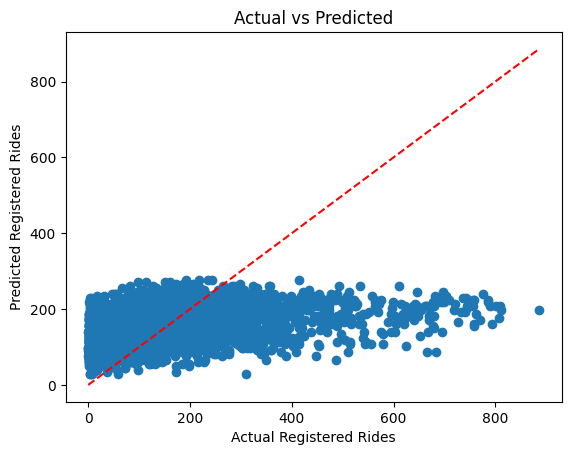

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Registered Rides")
plt.ylabel("Predicted Registered Rides")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


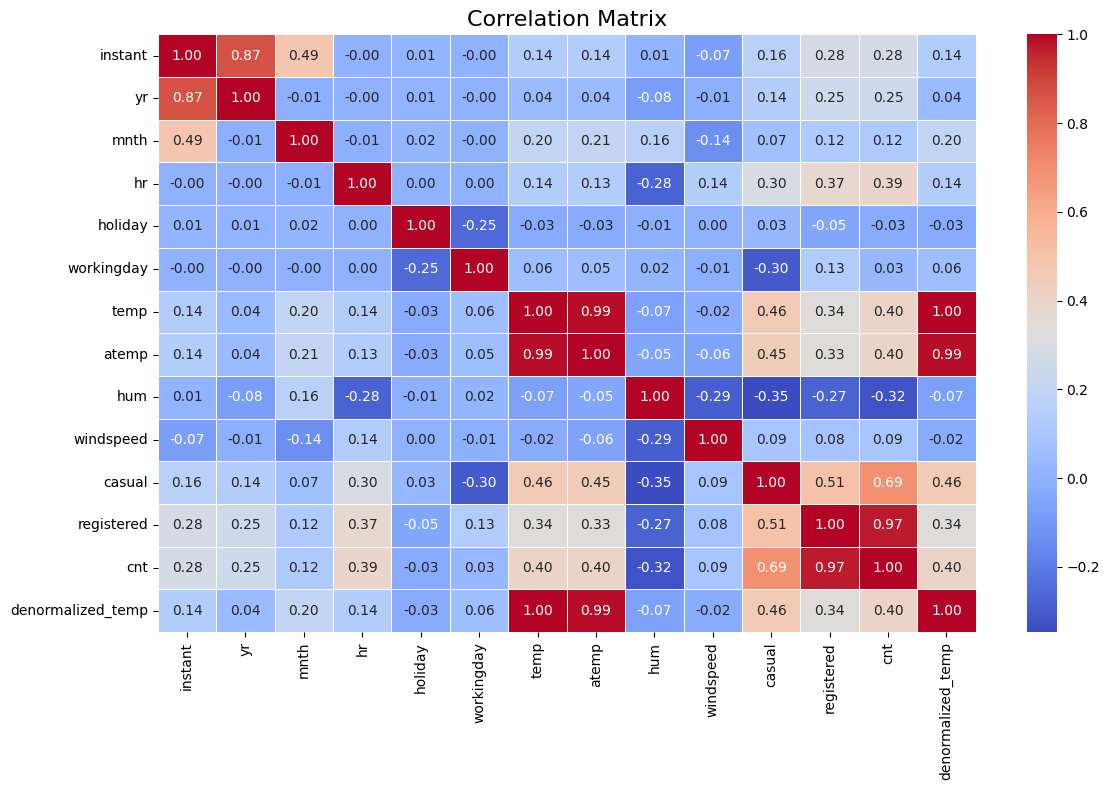

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = preprocessed_data.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()
